In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import json
import gradio as gr

In [2]:
load_dotenv()
api_key = os.getenv("OPENAI_API")
if api_key and api_key[:2] == "sk":
    print("API key is set")
else:
    print("Something went wrong")

API key is set


In [3]:
MODEL = "gpt-4o-mini"
openai = OpenAI(api_key=api_key)

In [4]:
system_prompt = \
"""
You are a helpful ai assistant  for an Airline called AirAI
Give short, relevent and consice answers, no more than 1 sentence
If you do not know about the answer just say I don't know.
"""

In [5]:
ticket_prices = {"hyderabad":"$15","vijayawada":"$25","delhi":"$10","bengaluru":"$15"}
def get_ticket_price(destination_city):
    city = destination_city.lower()
    return ticket_prices.get(city,"No Flights Avaliable") 

In [6]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of the ticket to the destination city. Call this whenever you need to know the ticket price.",
    "parameters": {
        "type": "object",  # JSON object
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that customer wants to travel to."
            }
        },
        "required": ["destination_city"],
        "additionalProperties": False  
    }
}


In [7]:
tools = [{"type":"function","function":price_function}]

In [8]:
def handle_tool_call(tool_call_msg):
    tool_call = tool_call_msg.tool_calls[0]
    args = json.loads(tool_call.function.arguments)
    city = args.get("destination_city")
    price = get_ticket_price(city)
    response = {
        "role":"tool",
        "tool_call_id": tool_call.id,
        "content":json.dumps({"destination_city":city,"price":price})
    }
    return response

In [ ]:
def chat(message,history):
    messages = [
        {"role":"system","content":system_prompt},
    ]
    for user_msg,assistent_msg in history:
        messages.append({"role":"user","content":user_msg})
        messages.append({"role":"assistant","content":assistent_msg})
    messages.append({"role":"user","content":message})
    response = openai.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools
    )
    )
    choice = response.choices[0]
    if choice.finish_reason == "tool_calls":
        tool_call_msg = choice.message  # assistant request
        tool_response_msg = handle_tool_call(tool_call_msg)
        messages.append(tool_call_msg)
        messages.append(tool_response_msg)
        response = openai.chat.completions.create(
            model=MODEL,
            messages=messages
        )
    return response.choices[0].message.content

In [10]:
gr.ChatInterface(fn=chat).launch()

d:\MASTERING_LLMs\llmEnv\lib\site-packages\gradio\chat_interface.py:339: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [11]:
import base64
from io import BytesIO
from PIL import Image

In [12]:
def artist(city):
    prompt = (
        f"Ultra-vibrant travel-poster illustration of {city} on a perfect holiday. "
        "Foreground: a cheerful visitor taking a selfie. "
        "Mid-ground: the city’s signature landmarks and skyline rendered in bold, saturated colors. "
        "Background: clear blue sky with stylized sun rays and playful clouds. "
        "Include small icons of local food, cultural symbols, and nature unique to the region, "
        "arranged around the composition like sticker art. "
        "Style: modern flat graphic poster, sharp lines, subtle paper-texture, cinematic lighting. "
        "4K resolution."
    )
    image_response = openai.images.generate(
        model='dall-e-3', 
        prompt=prompt,
        size = "1024x1024",
        n=1,
        response_format="b64_json"
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))
    

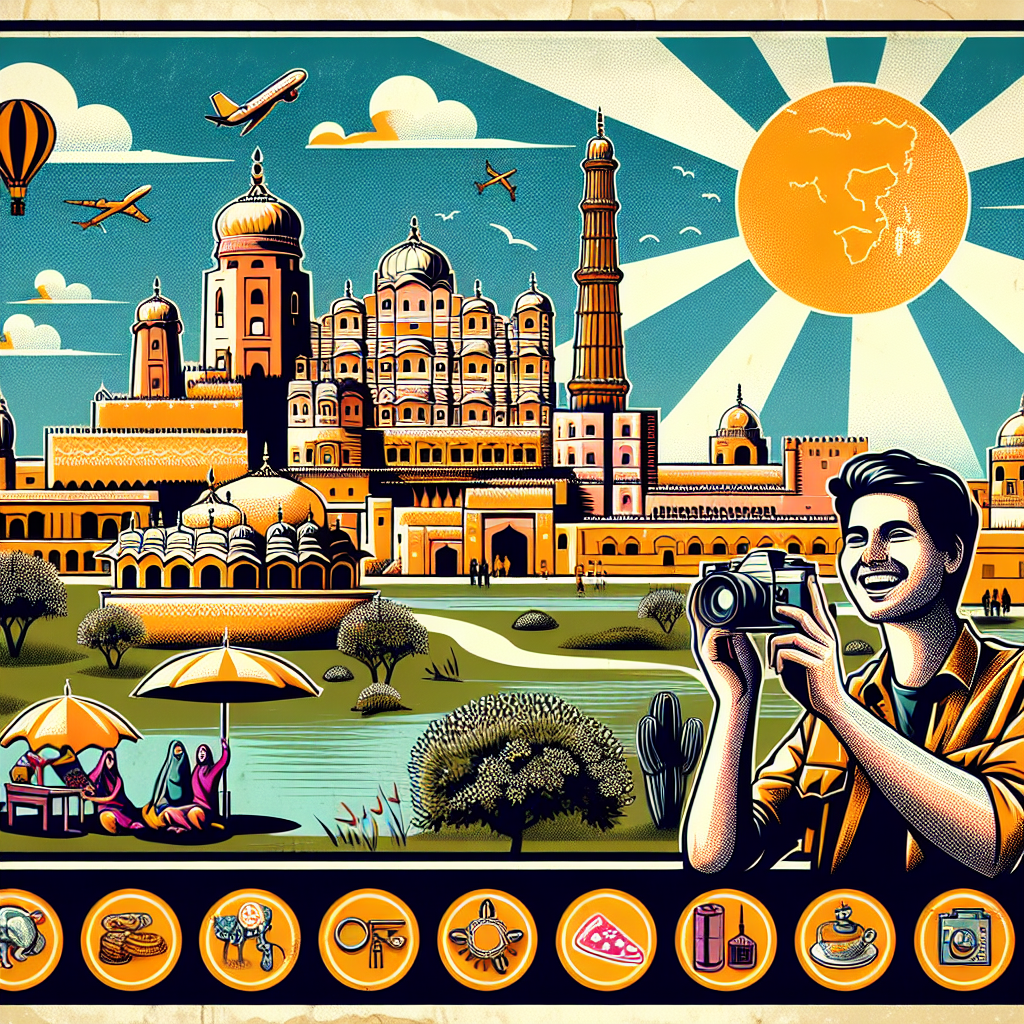

In [ ]:
# image = artist("Jaipur")
# display(image)

In [ ]:
from pydub import AudioSegment
from pydub.playback import play

def audio(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="alloy",
        input=message
    )
    audio_stream = BytesIO(response.content)
    speech = AudioSegment.from_file(audio_stream,format='mp3')
    play(audio_stream)


In [ ]:
# audio("Hi")